In [1]:
import jsonlines
import pandas as pd

# id 정보를 모아서 저장하는 예시
train_dict = {
    'id' : [],
    'sentence_form' : [],
    'annotation' : []
}

# open 내의 디렉토리 및 파일 이름에 유의
with jsonlines.open('nikluge-sa-2022-train.jsonl') as f:
    for line in f:
        train_dict['id'].append(line['id'])
        train_dict['sentence_form'].append(line['sentence_form'])
        train_dict['annotation'].append(line['annotation'])

In [2]:
train_df = pd.DataFrame(train_dict)

In [3]:
train_df.tail(15)

,id,sentence_form,annotation
2986,nikluge-sa-2022-train-02987,저렴이 유기농 클렌저,"[[제품 전체#가격, [저렴이 유기농 클렌저, 0, 11], positive]]"
2987,nikluge-sa-2022-train-02988,- 지우면서도 피부에 뭐 남는거 없이 깔끔한 느낌,"[[본품#품질, [None, 0, 0], positive]]"
2988,nikluge-sa-2022-train-02989,왜 오일은 바르면 피부 미끄덩해지니까 빨리 뽀득뽀득 씻고 싶은데 얘는 그런건 없음,"[[본품#품질, [None, 0, 0], neutral]]"
2989,nikluge-sa-2022-train-02990,하우스 뮤직이나 일렉음악을 들으시는 분이면 6만원이라는 가격에도 나쁘지 않은 이어폰...,"[[제품 전체#가격, [이어폰, 43, 46], neutral]]"
2990,nikluge-sa-2022-train-02991,"특히, 단선도 잘 안 당하는 극강 케이블인 점도 강점.","[[본품#품질, [케이블, 19, 22], positive]]"
2991,nikluge-sa-2022-train-02992,"다만, 착용감에서 호불호가 생길 수 있으니 반드시 청음 필수.","[[본품#품질, [None, 0, 0], neutral]]"
2992,nikluge-sa-2022-train-02993,비싸 ㅠㅠㅠ,"[[제품 전체#가격, [None, 0, 0], negative]]"
2993,nikluge-sa-2022-train-02994,지금 입었는데 매우 따뜻하고 따갑다,"[[제품 전체#품질, [None, 0, 0], neutral]]"
2994,nikluge-sa-2022-train-02995,보드랍고 아주 좋다,"[[제품 전체#품질, [None, 0, 0], positive]]"
2995,nikluge-sa-2022-train-02996,겨울에 코트 안에 유용하게 입을 듯.,"[[제품 전체#일반, [None, 0, 0], positive]]"


In [4]:
train_df['len'] = train_df.annotation.apply(lambda x : len(x))

In [5]:
import numpy as np
np.unique(train_df['len'], return_counts = True)

(array([1, 2, 3, 4, 5], dtype=int64),
 array([2766,  221,   10,    3,    1], dtype=int64))

In [6]:
def expand_row(row):
    labels = row["annotation"]
    if len(labels) >= 2:
        # 리스트 길이만큼 복사
        return pd.DataFrame({
            "id": [row["id"]] * len(labels),
            "sentence_form" : row['sentence_form'] * len(labels),
            "label": labels,
            "annotation_len": len(labels)
        })
    else:
        return pd.DataFrame({
            "id": [row["id"]],
            "sentence_form" : row['sentence_form'],
            "label": labels,
            "annotation_len" : 1
        })
    
train_df = pd.concat(train_df.apply(expand_row, axis=1).tolist(), ignore_index=True)

In [7]:
def extract_ACD_entity(row):
    return row[0].split("#")[0]

def extract_ACD_attribute(row):
    return row[0].split("#")[1]

def extract_ACD_word(row):
    return row[1][0]

train_df['ACD_entity'] = train_df.label.apply(extract_ACD_entity)
train_df['ACD_attribute'] = train_df.label.apply(extract_ACD_attribute)
train_df['ACD_word'] = train_df.label.apply(extract_ACD_word)

In [8]:
entity_cnt = train_df.ACD_entity.value_counts()
attribute_cnt = train_df.ACD_attribute.value_counts()

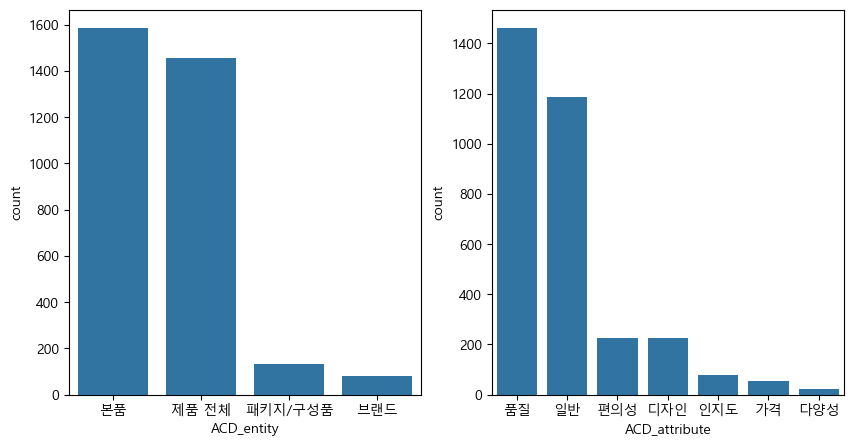

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
import seaborn as sns

fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.barplot(data = entity_cnt, ax = ax[0])
sns.barplot(data = attribute_cnt, ax = ax[1])
plt.show()

In [43]:
from sklearn.utils import resample
import pandas as pd

# (1) 조합별 개수 확인
group_counts = train_df.groupby(['ACD_entity', 'ACD_attribute']).size()

# (2) 최소 수치로 맞춤 (0은 제외)
min_count = group_counts[group_counts > 0].min()

# (3) 조합별 다운샘플링 수행
downsampled_list = []

for (entity, attr), group in train_df.groupby(['ACD_entity', 'ACD_attribute']):
    if len(group) >= min_count:
        sampled = resample(group, replace=False, n_samples=min_count, random_state=42)
        downsampled_list.append(sampled)

# (4) 합치기
downsampled_df = pd.concat(downsampled_list).reset_index(drop=True)


In [44]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("klue/roberta-base")
model = AutoModel.from_pretrained("klue/roberta-base")

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
import torch.nn as nn
class Bert_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("klue/roberta-base")
        self.classifier1 = nn.Linear(self.bert.config.hidden_size, 4)
        self.classifier2 = nn.Linear(self.bert.config.hidden_size, 7)
        self.classifier3 = nn.Linear(self.bert.config.hidden_size, 1)
    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask)
        x = x.pooler_output
        output1 = self.classifier1(x)
        output2 = self.classifier2(x)
        output3 = self.classifier3(x)
        return output1, output2, output3

In [46]:
from torch.utils.data import Dataset
import torch

class MultiTaskDataset(Dataset):
    def __init__(self, texts, entity_labels, attribute_labels, len_labels, tokenizer, max_len):
        self.texts = texts
        self.entity_labels = entity_labels
        self.attribute_labels = attribute_labels
        self.len_labels = len_labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        entity_label = torch.tensor(self.entity_labels[idx], dtype=torch.long)
        attribute_label = torch.tensor(self.attribute_labels[idx], dtype=torch.long)
        len_label = torch.tensor(self.len_labels[idx], dtype=torch.float32)

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'entity_label': entity_label,
            'attribute_label': attribute_label,
            'len_label' : len_label
        }

    
from sklearn.preprocessing import LabelEncoder

le_entity = LabelEncoder()
le_attribute = LabelEncoder()

entity_labels = le_entity.fit_transform(downsampled_df['ACD_entity'])
attribute_labels = le_attribute.fit_transform(downsampled_df['ACD_attribute'])

from torch.utils.data import DataLoader

dataset = MultiTaskDataset(
    texts=downsampled_df['sentence_form'].tolist(),
    entity_labels=entity_labels,
    attribute_labels=attribute_labels,
    len_labels=downsampled_df['annotation_len'],
    tokenizer=tokenizer,
    max_len=64
)

train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
EPOCHS = 10
ce = nn.CrossEntropyLoss()
mse = nn.MSELoss()

def train_model(model, train_loader, optimizer):
    model.train()
    avg_entity_losses, avg_attribute_losses, avg_number_losses = [], [], []
    for epoch in range(EPOCHS):
        total_entity_loss, total_attribute_loss, total_number_loss = 0, 0, 0
        for batch in train_loader:
            entity, attribute, number = model(batch['input_ids'], batch['attention_mask'])
            loss_entity = ce(entity, batch['entity_label'])
            loss_attribute = ce(attribute, batch['attribute_label'])
            loss_number = mse(number, batch['len_label'])
            optimizer.zero_grad()
            loss_entity.backward(retain_graph=True)
            loss_attribute.backward(retain_graph=True)
            loss_number.backward()
            optimizer.step()
            total_entity_loss += loss_entity.item()
            total_attribute_loss += loss_attribute.item()
            total_number_loss += loss_number.item()
        avg_entity_loss = total_entity_loss/len(train_loader)
        avg_attribute_loss = total_attribute_loss/len(train_loader)
        avg_number_loss = total_number_loss/len(train_loader)
        avg_entity_losses.append(avg_entity_loss)
        avg_attribute_losses.append(avg_attribute_loss)
        avg_number_losses.append(avg_number_loss)
        print(f"Epoch : {epoch+1} - Entity Loss = {avg_entity_loss}, Attribute Loss = {avg_attribute_loss}, Number Loss = {avg_number_loss}")
    return [avg_entity_losses, avg_attribute_losses, avg_number_losses]
            

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
bert_model = Bert_Classifier()  
avg_entity_losses, avg_attribute_losses, avg_number_losses = train_model(bert_model, train_loader, optimizer)

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\82102\anaconda3\envs\nlpenv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\82102\anaconda3\envs\nlpenv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self

Epoch : 1 - Entity Loss = 1.393614411354065, Attribute Loss = 1.9964961210886638, Number Loss = 1.9300565719604492
Epoch : 2 - Entity Loss = 1.4021520018577576, Attribute Loss = 1.9727323452631633, Number Loss = 1.822588562965393
Epoch : 3 - Entity Loss = 1.3826892375946045, Attribute Loss = 1.9962677160898845, Number Loss = 1.8170302708943684
Epoch : 4 - Entity Loss = 1.407431145509084, Attribute Loss = 1.9650733669598897, Number Loss = 1.8203529119491577
Epoch : 5 - Entity Loss = 1.400393545627594, Attribute Loss = 1.9728466272354126, Number Loss = 1.7625215252240498
Epoch : 6 - Entity Loss = 1.4099823832511902, Attribute Loss = 1.9830074707667034, Number Loss = 1.8070086638132732
Epoch : 7 - Entity Loss = 1.3907593886057537, Attribute Loss = 1.9521993001302083, Number Loss = 1.85880845785141
Epoch : 8 - Entity Loss = 1.4016164739926655, Attribute Loss = 1.9773895343144734, Number Loss = 1.7936594287554424
Epoch : 9 - Entity Loss = 1.4048242171605427, Attribute Loss = 1.9872948527336

TypeError: cannot unpack non-iterable NoneType object

{'input_ids': tensor([[    0,     3,  6925,  2471,  2052,  1125,  2227,  3072, 17598,  9416,
          2116,  1910,  2324, 31369,  1820,  2960,  3856,  2116,  4718, 17559,
            18,     2,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0